# Imports

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from typing import List, Callable, Tuple, Any
from wandb.wandb_run import Run
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier, Pool, metrics, cv

import attr
import pandas as pd
import gc
import os
import wandb
import nest_asyncio
import logging
import sys
import numpy as np

nest_asyncio.apply()

while "freqtrade" not in os.listdir():
    os.chdir("..")
    if "freqtrade" in os.listdir():
        nest_asyncio.apply()
        logger = logging.getLogger("freqtrade.ml")
        handler = logging.StreamHandler(stream=sys.stdout)
        handler.setFormatter(logging.Formatter("%(name)s - %(message)s"))
        logger.addHandler(handler)
        logger.setLevel(logging.DEBUG)
    
from freqtrade.ml.lightning import LightningModule, LightningConfig
from freqtrade.ml.trainer import TradingTrainer
from freqtrade.ml.container import LightningContainer
from freqtrade.ml import loader, lightning_utils

from freqtrade.nbtools.helper import free_mem
from freqtrade.nbtools.pairs import PAIRS_HIGHCAP_NONSTABLE

container = None

if container is not None:
    print("Deleting container")
    free_mem(container)
    
gc.collect()

0

# Lightning Module

In [23]:
attr.s(repr=False)
class CatBoost(LightningModule):
    """ Template for LightningModule """
        
    def on_configure(self) -> LightningConfig:
        
        # This datetime can be replaced with datetime.now()
        now = datetime(2021, 8, 10)
        
        # Lighting Configuration
        config = LightningConfig(
            
            # Basic info
            name        = "5n20-catboostzero",
            timeframe   = "5m",
            exchange    = "binance",
            
            # Train and validation datetime
            trainval_start  = now - timedelta(days=62),
            trainval_end    = now - timedelta(days=31),
            
            # Backtest Optimization datetime
            opt_start = now - timedelta(days=30),
            opt_end   = now - timedelta(days=15),
            
            # Unbiased Backtest datetime
            test_start = now - timedelta(days=14),
            test_end   = now,
        )
        
        # Optional custom config attributes
        config.add_custom("num_epochs", 2000)
        config.add_custom("num_future_candles", 4)
        config.add_custom("num_classification_classes", 3)
        config.add_custom("hardware", "CPU")
        
        return config
        
    def on_get_data_paths(self, cwd: Path, timeframe: str, exchange: str) -> List[Path]:
        path_data_exchange = cwd.parent / "mount" / "data" / exchange

        return [
            datapath
            for datapath in list(path_data_exchange.glob(f"*-{timeframe}.json"))
            if datapath.name.split("-")[0].replace("_", "/")
            in PAIRS_HIGHCAP_NONSTABLE
        ]
    
    def on_add_features(self, df_onepair: pd.DataFrame) -> pd.DataFrame:
        import talib.abstract as ta
        import pandas_ta as pdta
        import freqtrade.vendor.qtpylib.indicators as qtpylib

        # Start add features (EVEN ONLY!)
        spaces = [4, 8, 14, 26, 50, 76, 100, 200]
        
        for i in spaces:
            i_half = int(i / 2)
            
            df_onepair[f"ml_is_above_ema{i}"] = df_onepair["close"] > ta.EMA(df_onepair["close"], timeperiod=i)
            
            df_onepair["macd"], df_onepair["macdsignal"], _ = ta.MACD(df_onepair["close"], 
                                                 fastperiod=i_half, 
                                                 slowperiod=i, 
                                                 signalperiod=9)
            df_onepair[f"ml_is_macd{i}_crossup"] = qtpylib.crossed_above(df_onepair["macd"], df_onepair["macdsignal"])
            df_onepair[f"ml_is_macd{i}_crossdown"] = qtpylib.crossed_below(df_onepair["macd"], df_onepair["macdsignal"])
            df_onepair = df_onepair.drop(columns=["macd", "macdsignal"])
            
            df_onepair[f"ml_is_rsi{i}_above50"] = ta.RSI(df_onepair["close"], timeperiod=i) > 50
            
            tema = ta.TEMA(df_onepair["close"], timeperiod=i)
            df_onepair[f"ml_is_tema{i}_crossup"] = qtpylib.crossed_above(df_onepair["close"], tema)
            df_onepair[f"ml_is_tema{i}_crossdown"] = qtpylib.crossed_below(df_onepair["close"], tema)
            
            df_onepair[f"ml_is_volume_above_ema{i}"] = df_onepair["volume"] > ta.EMA(df_onepair["volume"], timeperiod=i)

        return df_onepair
    
    def on_add_labels(self, df_onepair: pd.DataFrame) -> pd.DataFrame:
        # Create labels for classification task
        future_price = df_onepair['close'].shift(-self.config.num_future_candles)
        ml_label = (future_price - df_onepair['close']) / df_onepair['close']
        df_onepair[self.config.column_y] = pd.qcut(ml_label, self.config.num_classification_classes, labels=False)
        return df_onepair
    
    def on_final_processing(self, df_allpairs: pd.DataFrame) -> Tuple[Any, Any, Any, Any]:
        df_allpairs = self._balance_class_dataset(df_allpairs)
        X = df_allpairs[self.config.columns_x]
        y = df_allpairs[self.config.column_y]
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
        return X_train, X_val, y_train, y_val
    
    def _balance_class_dataset(self, df_allpairs: pd.DataFrame) -> pd.DataFrame:
        """Balance num of datas in every class"""
        lengths_every_class = list(df_allpairs.groupby(by=["ml_label"]).count()["date"])
        df_allpairs_copy = pd.DataFrame()

        for classname in df_allpairs["ml_label"].unique():
            minimum_of_all = min(lengths_every_class)
            df_allpairs_copy = df_allpairs_copy.append(df_allpairs.loc[df_allpairs["ml_label"] == classname, :].iloc[:minimum_of_all])

        # Performance improvements
        df_allpairs_copy = df_allpairs_copy.astype(
            {col: "float32" for col in df_allpairs_copy.columns if "float" in str(df_allpairs_copy[col].dtype)}
        )
        free_mem(df_allpairs)
        return df_allpairs_copy
    
    def on_define_model(self, run: Run, X_train, X_val, y_train, y_val) -> Any:
        return CatBoostClassifier(
            iterations=self.config.num_epochs, 
            task_type=self.config.hardware,
         )
    
    def on_start_training(self, run: Run, X_train, X_val, y_train, y_val):
        print("Start Training...")
        self.model: CatBoostClassifier
        self.model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)]
        )
        print("Accuracy: %.2f" % self.model.score(X_val, y_val))
    
    def on_predict(self, df_input_onepair: pd.DataFrame) -> pd.DataFrame:
        df_input_np = df_input_onepair.to_numpy()
        preds = self.model.predict_proba(df_input_np)
        df_preds = pd.DataFrame(preds)
        
        return df_preds
    
    def on_training_step(self, run: Run, data: dict):
        raise NotImplementedError()


module = CatBoost()

# Dataset EDA Before Training

In [24]:
df_: pd.DataFrame = lightning_utils.get_dataset_df(module)
dates = df_["date"]
df_ = df_[module.config.columns_x + [module.config.column_y]]
df_

,ml_is_above_ema4,ml_is_macd4_crossup,ml_is_macd4_crossdown,ml_is_rsi4_above50,ml_is_tema4_crossup,ml_is_tema4_crossdown,ml_is_volume_above_ema4,ml_is_above_ema8,ml_is_macd8_crossup,ml_is_macd8_crossdown,...,ml_is_tema100_crossdown,ml_is_volume_above_ema100,ml_is_above_ema200,ml_is_macd200_crossup,ml_is_macd200_crossdown,ml_is_rsi200_above50,ml_is_tema200_crossup,ml_is_tema200_crossdown,ml_is_volume_above_ema200,ml_label
68220,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.0
68221,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.0
68222,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1.0
68223,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,2.0
68224,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248488,False,False,False,False,True,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,1.0
248489,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,1.0
248490,True,True,False,True,False,False,False,True,False,False,...,False,False,True,False,False,True,False,False,False,1.0
248491,True,False,False,True,False,True,False,True,False,False,...,False,False,True,False,False,True,False,False,False,0.0


In [25]:
def dataframe_statistics(df_: pd.DataFrame):
    # Detect nan, infinity, and too large values in dataset
    print("N rows na:", str(df_.shape[0] - df_.dropna().shape[0]))
    print("N rows inf:", str(df_.shape[0] - df_.replace([np.inf, -np.inf], np.nan).dropna().shape[0]))
    print("Cols na:", str(df_.columns[df_.isna().any()].tolist()))
    print("Cols inf:", str(list(df_.columns.to_series()[np.isinf(df_).any()])))

    # Detect columns with irregular datatypes
    supported_datatypes = ["float32"]
    print("Irregular (col, dtypes):", str([(it, df_[it].dtype) for it in df_.columns if df_[it].dtype not in supported_datatypes]))

    # Dataset statistics
    print("Dataset Length: %s" % len(df_))
    print("Date Min: %s" % dates.min())
    print("Date Max: %s" % dates.max())
    print("Num feature columns: %i" % (len(df_.columns) - 1))
    
dataframe_statistics(df_)

N rows na: 0
N rows inf: 0
Cols na: []
Cols inf: []
Irregular (col, dtypes): [('ml_is_above_ema4', dtype('bool')), ('ml_is_macd4_crossup', dtype('bool')), ('ml_is_macd4_crossdown', dtype('bool')), ('ml_is_rsi4_above50', dtype('bool')), ('ml_is_tema4_crossup', dtype('bool')), ('ml_is_tema4_crossdown', dtype('bool')), ('ml_is_volume_above_ema4', dtype('bool')), ('ml_is_above_ema8', dtype('bool')), ('ml_is_macd8_crossup', dtype('bool')), ('ml_is_macd8_crossdown', dtype('bool')), ('ml_is_rsi8_above50', dtype('bool')), ('ml_is_tema8_crossup', dtype('bool')), ('ml_is_tema8_crossdown', dtype('bool')), ('ml_is_volume_above_ema8', dtype('bool')), ('ml_is_above_ema14', dtype('bool')), ('ml_is_macd14_crossup', dtype('bool')), ('ml_is_macd14_crossdown', dtype('bool')), ('ml_is_rsi14_above50', dtype('bool')), ('ml_is_tema14_crossup', dtype('bool')), ('ml_is_tema14_crossdown', dtype('bool')), ('ml_is_volume_above_ema14', dtype('bool')), ('ml_is_above_ema26', dtype('bool')), ('ml_is_macd26_crossup', 

68220     0.0
68221     0.0
68222     1.0
68223     2.0
68224     2.0
         ... 
248488    1.0
248489    1.0
248490    1.0
248491    0.0
248492    1.0
Name: ml_label, Length: 553350, dtype: float32


<AxesSubplot:>

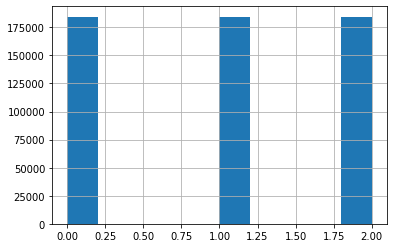

In [26]:
# Dataset labels
print(df_["ml_label"])
df_["ml_label"].hist()

In [7]:
# Unload dataset after EDA to save memory
free_mem(df_)

# [-Start Training-]

In [8]:
with wandb.init(project=module.config.name) as run:
    trainer = TradingTrainer()
    container = trainer.fit(module, run, True)

wandb: Currently logged in as: jliberooo (use `wandb login --relogin` to force relogin)


Start Training...
Learning rate set to 0.09578
0:	learn: 1.6019542	test: 1.6019320	best: 1.6019320 (0)	total: 604ms	remaining: 20m 7s
1:	learn: 1.5956477	test: 1.5956750	best: 1.5956750 (1)	total: 1.07s	remaining: 17m 45s
2:	learn: 1.5902325	test: 1.5902547	best: 1.5902547 (2)	total: 1.55s	remaining: 17m 15s
3:	learn: 1.5856025	test: 1.5855804	best: 1.5855804 (3)	total: 2.01s	remaining: 16m 45s
4:	learn: 1.5816336	test: 1.5816338	best: 1.5816338 (4)	total: 2.51s	remaining: 16m 40s
5:	learn: 1.5781305	test: 1.5781454	best: 1.5781454 (5)	total: 3s	remaining: 16m 36s
6:	learn: 1.5749946	test: 1.5750415	best: 1.5750415 (6)	total: 3.5s	remaining: 16m 35s
7:	learn: 1.5720997	test: 1.5720975	best: 1.5720975 (7)	total: 3.98s	remaining: 16m 29s
8:	learn: 1.5695563	test: 1.5695517	best: 1.5695517 (8)	total: 4.47s	remaining: 16m 28s
9:	learn: 1.5673494	test: 1.5673473	best: 1.5673473 (9)	total: 4.94s	remaining: 16m 22s
10:	learn: 1.5653940	test: 1.5653446	best: 1.5653446 (10)	total: 5.41s	remaini

wandb: Adding directory to artifact (C:\CS\Python\crypto-collection\freqtrade\superft\.temp\lightning_5n20-catboostbasic_2021-08-17_14-40-22)... Done. 0.1s


# Predictions EDA

In [4]:
# Validate prediction function by simulate inserting freqtrade data into predict function
df_with_preds = trainer.validate_predict(container)
df_with_preds

freqtrade.ml.container - Not dropping X columns in predict because it doesn't exist in predict columns


INFO:freqtrade.ml.container:Not dropping X columns in predict because it doesn't exist in predict columns


freqtrade.ml.container - Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2']


INFO:freqtrade.ml.container:Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2']



Dataset: Binance BTC/USDT 5m loc[410000:414000] (Freqtrade Regularized)


DF WITH PREDICTIONS INFO
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 410000 to 414000
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   date    4001 non-null   datetime64[ns, UTC]
 1   open    4001 non-null   float64            
 2   high    4001 non-null   float64            
 3   low     4001 non-null   float64            
 4   close   4001 non-null   float64            
 5   volume  4001 non-null   float64            
 6   ml_0    3602 non-null   float64            
 7   ml_1    3602 non-null   float64            
 8   ml_2    3602 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(8)
memory usage: 281.4 KB
None


Original DF
----------
                            date      open      high       low     close  \
410000 2021-07-10 18:40:00+00:00  33434.42  33446.42  33390.76  3

,date,open,high,low,close,volume,ml_0,ml_1,ml_2
410000,2021-07-10 18:40:00+00:00,33434.42,33446.42,33390.76,33402.09,87.119679,NaN,NaN,NaN
410001,2021-07-10 18:45:00+00:00,33401.41,33432.15,33401.40,33416.81,44.021276,NaN,NaN,NaN
410002,2021-07-10 18:50:00+00:00,33416.81,33437.78,33413.39,33421.01,47.821799,NaN,NaN,NaN
410003,2021-07-10 18:55:00+00:00,33421.01,33468.98,33420.01,33466.71,38.742812,NaN,NaN,NaN
410004,2021-07-10 19:00:00+00:00,33466.71,33544.00,33448.99,33535.73,147.871811,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
413996,2021-07-24 15:40:00+00:00,33871.76,33873.99,33816.98,33843.32,212.499511,0.426122,0.314029,0.259849
413997,2021-07-24 15:45:00+00:00,33843.31,33874.87,33817.00,33874.86,104.111770,0.304206,0.526346,0.169448
413998,2021-07-24 15:50:00+00:00,33874.86,33899.61,33854.21,33898.25,63.273788,0.273062,0.296775,0.430162
413999,2021-07-24 15:55:00+00:00,33898.25,33898.25,33843.41,33847.51,139.420180,0.474057,0.221199,0.304743


In [5]:
container.config

AttributeError: 'LightningContainer' object has no attribute 'config'